<a href="https://colab.research.google.com/github/vuchicago/Python/blob/master/Cement_Forecasting_LSTM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
####MOUNT DRIVE
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)


Mounted at /content/gdrive


In [2]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 46kB/s 
     |████████████████████████████████| 501kB 70.6MB/s 
     |████████████████████████████████| 3.1MB 32.9MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import os

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime as dt

base_dir="/content/gdrive/My Drive/Python/Forecasting"

os.chdir(base_dir)

In [11]:
tf.__version__

'2.0.0-beta1'

In [0]:
Cement=pd.read_csv('Cement_sales.csv', thousands=',')
Cement["Billing Date"]=pd.to_datetime(Cement["Billing Date"])
Cement=Cement.set_index("Billing Date")
Cement=Cement.drop('Sales Office',axis=1)
Cement=Cement.replace(np.NaN,0)


In [0]:
Cement_mean=dict(Cement.mean())
Cement_std=dict(Cement.std())


In [0]:
print(Cement_std)
print(Cement_mean)

{'Total': 29207.358318457624, 'Midwest Region': 7991.846749749277, 'Mountain': 3187.293212468809, 'Southern Region': 5578.148962131978, 'TX/OK': 4200.964373238681, 'Northeast': 4885.22192903588, 'HUS Trade Sales': 2352.576372885502, 'North Central Region': 4502.359784417358, 'Inside Sales': 191.2214871490192}
{'Total': 43407.42086586231, 'Midwest Region': 9549.119533527697, 'Mountain': 5659.755378486056, 'Southern Region': 9151.198146828225, 'TX/OK': 7061.257754800591, 'Northeast': 7047.133283693224, 'HUS Trade Sales': 1448.2647554806072, 'North Central Region': 5819.326071169208, 'Inside Sales': 271.3793445878848}


In [0]:
for i in Cement.columns:
  Cement[i]=(Cement[i]-Cement_mean[i])/Cement_std[i]



In [0]:
Cement

,Total,Midwest Region,Mountain,Southern Region,TX/OK,Northeast,HUS Trade Sales,North Central Region,Inside Sales
Billing Date,,,,,,,,,
2016-01-01,70,0.0,24.0,0.0,22.0,0.0,0.0,24.0,0.0
2016-01-02,652,23.0,48.0,516.0,65.0,0.0,0.0,0.0,0.0
2016-01-03,463,47.0,0.0,134.0,91.0,122.0,46.0,23.0,0.0
2016-01-04,21942,2388.0,3448.0,8284.0,4989.0,1592.0,833.0,409.0,0.0
2016-01-05,27139,2840.0,3246.0,10822.0,7682.0,1120.0,1026.0,404.0,0.0
...,...,...,...,...,...,...,...,...,...
2019-11-06,73943,15830.0,8652.0,17096.0,11324.0,10833.0,0.0,9812.0,395.0
2019-11-07,64642,17741.0,8374.0,14511.0,4978.0,10945.0,0.0,7749.0,344.0
2019-11-08,65359,15228.0,9602.0,15053.0,6782.0,10530.0,215.0,7758.0,191.0


In [0]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
  series=tf.expand_dims(series,axis=-1) ##has to be a series.  Can't convert a dataframe unless it's a numpy matrix
  dataset=tf.data.Dataset.from_tensor_slices(series) ##Turn a series into a tensorflow dataseries
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) ###tf will create a window in the series 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:])) #All but the last entry; The last entry
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
def windowed_dataset_1(series,window_size,batch_size,shuffle_buffer):
  series=tf.expand_dims(series,axis=-1) ##has to be a series.  Can't convert a dataframe unless it's a numpy matrix
  dataset=tf.data.Dataset.from_tensor_slices(series) ##Turn a series into a tensorflow dataseries
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) ###tf will create a window in the series 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  df = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1]) )#All but the last entry; The last entry
  return df

In [0]:
a=windowed_dataset_1(Cement["Total"],window_size,batch_size,shuffle_buffer_size)

In [0]:
check=tf.data.Dataset.from_tensor_slices([])
for col in Cement:
  df=windowed_dataset_1(Cement[col],window_size,batch_size,shuffle_buffer_size)

return check


In [0]:
tf.data.Dataset.from_tensor_slices([])

<TensorSliceDataset shapes: (), types: tf.float32>

In [0]:
for i in check:
  print(i[-1:])

tf.Tensor([[4348.  381.  235. 1254. 2014.  308.   nan  157.   nan]], shape=(1, 9), dtype=float64)


In [0]:
split_time = 1000
time_train=Cement.index[:split_time]
x_train = Cement[:split_time]
time_valid=Cement.index[split_time:]
x_valid = Cement[split_time:]
window_size = 365
batch_size = 10
shuffle_buffer_size = 1000

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


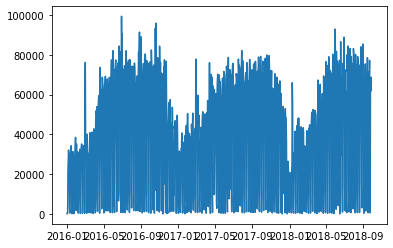

In [0]:
plt.plot(time_train,x_train["Total"])

In [0]:
df=windowed_dataset(x_train["Total"],window_size,batch_size,shuffle_buffer_size)

df_val=windowed_dataset(x_valid["Total"],window_size,batch_size,shuffle_buffer_size)

In [0]:
for x,y in df_val:
  print(x.numpy())


In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
  #tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(df, epochs=100,validation_data=df_val) #callbacks=[lr_schedule])

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
64/64 [==============================] - 25s 395ms/step - loss: 42754.7747 - mae: 42625.3047 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
64/64 [==============================] - 23s 356ms/step - loss: 42752.7726 - mae: 42625.3047 - val_loss: 52936.4711 - val_mae: 53139.4414
Epoch 3/100
64/64 [==============================] - 23s 355ms/step - loss: 42752.7722 - mae: 42625.3047 - val_loss: 52936.4711 - val_mae: 53139.4414
Epoch 4/100
12/64 [====>.........................] - ETA: 18s - loss: 40027.5573 - mae: 40028.1641

In [0]:
z1history.history

In [0]:

model.save("Cement_lstm_v2.h5")

In [0]:
model=tf.keras.models.load_model("Cement_lstm.h5")


In [0]:
from matplotlib import pyplot as plt
import matplotlib 

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 8)

plt.plot(np.arange(0,40),history.history['mae'],history.history['val_mae'])
plt.legend("train",'val')



In [0]:
model.summary()

In [0]:


forecast=[]
for time in range(len(Cement) - window_size):
  forecast.append(model.predict(tf.expand_dims(Cement["Total"][time:time + window_size,np.newaxis],axis=-1)))
#forecast=[i*Cement_std["Total"]+Cement_mean["Total"] for i in forecast]
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]



In [0]:
results

In [0]:
Cement["Total"].shape

(1409,)

In [0]:
Cement["Total"][1:366]

Billing Date
2016-01-02      652
2016-01-03      463
2016-01-04    21942
2016-01-05    27139
2016-01-06    32128
              ...  
2016-12-27    39447
2016-12-28    49525
2016-12-29    40958
2016-12-30    26420
2016-12-31     4294
Name: Total, Length: 365, dtype: int64

In [0]:
def forecast_series(model,series,window_size):
  series=tf.expand_dims(series,axis=-1)
  df=tf.data.Dataset.from_tensor_slices(series)
  df=df.window(window_size,shift=1,drop_remainder=True)
  df= df.flat_map(lambda window: window.batch(window_size + 1))
  df=df.batch(32).prefetch(1)
  forecast=model.predict(df)
  return forecast

In [0]:
###This one is for RNN only

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [0]:
list(Cement["Total"][213:578,np.newaxis,np.newaxis])

In [0]:
#forecast_series(model,Cement["Total"][12:377],1)
model.predict(Cement["Total"][213:578,np.newaxis,np.newaxis])[1,0,0]

13437.723

In [0]:
model.pre

In [0]:
(tf.expand_dims(Cement["Total"][time:time + window_size,np.newaxis],axis=-1)).shape

TensorShape([365, 1, 1])

In [0]:
model.weights[1]

<tf.Variable 'conv1d_1_1/bias:0' shape=(32,) dtype=float32, numpy=
array([-2430.4746 , -1926.6052 , -3708.2527 , -4894.996  , -6094.674  ,
        1739.574  ,  1909.6488 , -6797.9688 ,  2505.6748 , -2572.5254 ,
        5665.5435 , -2752.2795 ,  7396.615  , -2938.208  ,  1246.63   ,
       -2694.925  ,  4237.803  ,  1793.0839 ,   708.55396,   891.8063 ,
        -565.987  ,  -601.5373 , -3146.9983 , -3470.1467 , -3417.4646 ,
       -9875.342  , -8124.54   , -4618.5767 ,  1072.9496 , -2860.7893 ,
         616.7987 , -4002.485  ], dtype=float32)>

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    


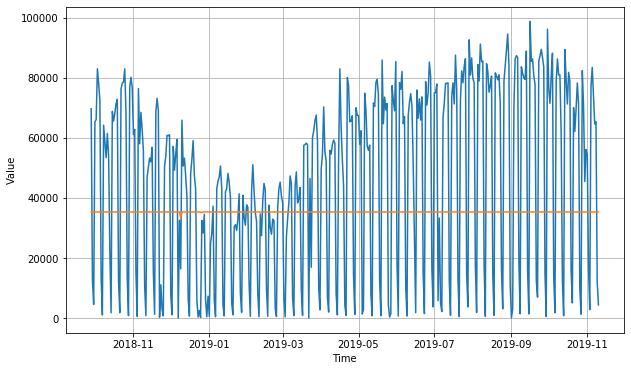

In [0]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid["Total"])
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid,results).numpy()

array([1.2678116e+09, 1.2678116e+09, 1.2678116e+09, 1.2678116e+09,
       1.2678116e+09, 1.2678116e+09, 1.2678116e+09, 1.2678116e+09,
       1.2678116e+09, 1.2678116e+09, 1.2678116e+09, 1.2678116e+09,
       1.2678116e+09, 1.2678116e+09, 1.2678116e+09, 1.2678116e+09,
       1.2678116e+09, 1.2678116e+09, 1.2678116e+09, 1.2678116e+09,
       1.2678116e+09, 1.2678116e+09, 1.2678116e+09, 1.2678116e+09,
       1.2678116e+09, 1.2678116e+09, 1.2678116e+09, 1.2678116e+09,
       1.2678116e+09, 1.2678116e+09, 1.2678116e+09, 1.2678116e+09,
       1.2678116e+09, 1.2678116e+09, 1.2678116e+09, 1.2678116e+09,
       1.2678116e+09, 1.2678116e+09, 1.2678116e+09, 1.2678116e+09,
       1.2678116e+09, 1.2678116e+09, 1.2678116e+09, 1.2678116e+09,
       1.2678116e+09, 1.2678116e+09, 1.2678116e+09, 1.2678116e+09,
       1.2678116e+09, 1.2678116e+09, 1.2678116e+09, 1.2678116e+09,
       1.2678116e+09, 1.2678116e+09, 1.2678116e+09, 1.2678116e+09,
       1.2678116e+09, 1.2678116e+09, 1.2678116e+09, 1.2678116e

In [0]:
tf.keras.metrics.mean_absolute_percentage_error(x_valid["Total"],results.numpy())

AttributeError: ignored

In [0]:
pd.Series(results).shape

Exception: ignored